In [1]:
# Author: Boccardi Francesca
# Email: francesca.boccardi@studio.unibo.it

# **System for Visual Inspection of Motorcycle Connecting Rods**

## Libraries import

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math

%matplotlib inline 

## System's functions definitions

In [3]:
def median_filter(img):

    '''
    Apply to `img` a 3x3 median filter for 5 times
    '''
      
    median = img.copy()

    for i in range(0,5):
        median = cv2.medianBlur(median, 3)
      
    return median

In [4]:
def show_connected_components(labels, i):

    '''
    Show connected components using pseudo-colors
    '''
    
    label_hue = np.uint8(i * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    plt.imshow(labeled_img)
    plt.title('Labeled connected components')
    plt.show()

In [5]:
def detach(img):

    '''
    If needed, apply a detachment rods process to `img`. 
    If no detachment is needed, return the input image and been_detached = `False`.
    Otherwise, show the contact points from which to perform the cut and return the detached image with been_detached = `True`
    '''

    (n_labels, labels, stats, _) = cv2.connectedComponentsWithStats(img, 4, cv2.CV_32S)

    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  
    final_img = rgb_img.copy()  
    been_detached = False


    for i in range(1, n_labels):

        # If the i-th component has an area bigger than 6000, it is assumed to contain more than one rod, been labeled as a single blob because of contact points
        if stats[i, cv2.CC_STAT_AREA] > 6000:

            # Extract i-th component from the image
            void_img = np.zeros((rgb_img.shape[0], rgb_img.shape[1]), dtype="uint8")
            component_mask = (labels == i).astype("uint8") * 255 
            component = cv2.bitwise_or(void_img, component_mask)

            # Find component contour
            component_cnt, _ = cv2.findContours(component,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
            contour = component_cnt[0]

            # Approximate the contour with a polygonal curve and find the convex hull of it
            cnt_curve = cv2.approxPolyDP(contour, 0.005 * cv2.arcLength(contour, False), True)
            hull_ids = cv2.convexHull(cnt_curve, returnPoints = False)
            
            # Find the convexity defects of the contour with respect to the convex hull
            defects_ids = cv2.convexityDefects(cnt_curve, hull_ids)

            if defects_ids is not None:
                defects_ids = defects_ids.reshape(-1,4)
                been_detached = True
            else:
                # No convexity defects, so no detachment needed
                return img, been_detached


            # For each vector d in defect_ids, d[2] is the index in the original contour of the farthest point from the hull
            defects_points = []
            for d in defects_ids:
                # Append convexity defect point
                defects_points.append(cnt_curve[d[2]].reshape(-1))

            # Detect only pairs of points closer than 25 (contact points)
            l = len(defects_points)
            contact_points_ids = {}
            
            for i in range(0, round(l/2)):
                for j in range(i+1, l):
                    dist = np.linalg.norm(defects_points[i]-defects_points[j])
                    if(dist < 25):
                        contact_points_ids[i] = j
          

            # For each pair of contact points, connect them with a black line
            contacts_img = rgb_img.copy()
            detached_img = rgb_img.copy()

            for i in contact_points_ids.keys():
                p1 = list(defects_points[i])
                p2 = list(defects_points[contact_points_ids.get(i)])
                contacts_img = cv2.circle(contacts_img, p1, radius=2, color=(255, 0, 0), thickness=-1)
                contacts_img = cv2.circle(contacts_img, p2, radius=2, color=(255, 0, 0), thickness=-1)
                detached_img = cv2.line(detached_img, p1, p2, color=(0,0,0), thickness=1, lineType=cv2.LINE_4) 
                final_img = cv2.line(final_img, p1, p2, color=(0,0,0), thickness=1, lineType=cv2.LINE_4) 

            plt.imshow(contacts_img)
            plt.title('Contact points')
            plt.show()       

    return final_img, been_detached

In [6]:
def get_centroid(contour):

    '''
    Compute centroid position of the component whose `contour` is passed as input
    '''
    
    # Compute moments for the contour
    M = cv2.moments(contour)

    # Compute (x, y) coordinates of the centroid
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])

    return cx, cy

In [7]:
def bounding_box(contour):

    '''
    Return the bounding box of the rod whose `contour` is passed as input
    '''
    
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    
    return rect, box

In [8]:
def get_orientation(contour):

    '''
    Compute the orientation of the rod whose `contour` is passed as input
    '''

    # Fit an ellipse around 'contour' and take the angle
    _, _, angle = cv2.fitEllipse(contour)
    
    # Compute the orientation angle
    orientation = (90-angle)%180

    return orientation

In [9]:
def get_type(rod_holes_number):

    '''
    Return the type of the rod based on the counting of its holes
    '''

    if(rod_holes_number == 1):
        return 'A'
    else:
        return 'B'

In [10]:
def get_dimensions(contour):

    '''
    Compute the width and the length of the rod whose `contour` is passed as input
    '''
    
    # Find the bounding box around 'contour'
    rect, _ = bounding_box(contour)
    
    # Extract width and length
    if (rect[1][0] >= rect[1][1]):
        length = rect[1][0]
        width = rect[1][1]
    else:
        width = rect[1][0]
        length = rect[1][1]
    
    return width, length

In [11]:
def get_barycenter_width(img, contour, barycenter, orientation):

    '''
    Compute the width at the barycenter of the rod whose `contour`, `barycenter` and `orientation` are passed as inputs
    '''
    
    bx, by = barycenter
 
    # Compute the equation of the line passing through the barycenter, perpendicular to the rod 'orientation'
    if orientation > 90:
        angle = orientation - 90
    else:
        angle = orientation + 90
    
    m = (math.tan(-angle*math.pi/180))
    
    if not math.isinf(m): 
        y = lambda x : m*(x - bx) + by
    
        x_min, y_min, x_max, y_max = 0, 0, img.shape[0], img.shape[1]

        if (y(x_max) <= y_max):
            y_min = y(x_min)
            y_max = y(x_max)
        else:
            x_min = (y_min-by)/m + bx
            x_max = (y_max-by)/m + bx
    else:
        x_min, y_min, x_max, y_max = bx, 0, bx, img.shape[1]
    
    # Draw the line on a blank image
    img_line = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    img_line = cv2.line(img_line, (round(x_min),round(y_min)), (round(x_max),round(y_max)), color=(255,255), thickness=1) 
    
    # Draw the contour on a different blank image
    img_cnt = np.zeros((img.shape[0],img.shape[1]), np.uint8)
    img_cnt = cv2.drawContours(img_cnt, [contour], 0 ,(255,255), 1, cv2.LINE_4)

    # Bitwise And between the masks of the two images, in order to find the intersection between the line and the contour
    mask_line = (img_line == 255).astype('uint8')
    mask_cnt = (img_cnt == 255).astype('uint8')
    and_img = cv2.bitwise_and(mask_cnt, mask_line)
    and_img = and_img*255
    
    # Extract intersection points
    and_points = np.argwhere(and_img == 255)
            
    y1,x1 = and_points[0]
    y2,x2 = and_points[-1]
    
    # Compute the barycenter width as the distance between the two intersection points
    bar_width = np.linalg.norm((x1-x2, y1-y2))

    return bar_width, (x1, y1), (x2, y2)

In [12]:
def haralick_circularity(barycenter, contour):

    '''
    Compute the Haralick Circularity value for the component whose `contour` and `barycenter` are passed as inputs
    '''
    
    n = len(contour) 
    mean = sum([np.linalg.norm(barycenter-contour[i]) for i in range(0,n)])/n
    std = np.sqrt(sum([pow(np.linalg.norm(barycenter-contour[i])-mean, 2) for i in range(0,n)])/n)
    
    return mean / std if std > 0 else float("INF")

In [13]:
def get_holes_features(img, component):

    '''
    Return holes' number, centroid positions, diameter sizes and contours of `component`
    '''
    
    # Apply closing morphology operation to restore possibly deterioration of holes
    kernel = np.ones((5,5),np.uint8)
    component = cv2.morphologyEx(component, cv2.MORPH_CLOSE, kernel)

    # Find all contours (external one + internal ones)
    all_cnts, _ = cv2.findContours(component, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    
    # Find external contour only
    out_cnt, _ = cv2.findContours(component, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Compute number of holes
    holes_number = len(all_cnts)-1
    
    # Extract holes contours only
    out_cnt = np.asarray(out_cnt, dtype='object')
    all_cnts = np.asarray(all_cnts, dtype='object')
       
    flat_out_cnt = out_cnt.reshape(-1)
    flat_all_cnts = []

    for a in all_cnts:
        flat_all_cnts.append(a.reshape(-1))

    flat_out_cnt = np.array(flat_out_cnt, dtype='object')
    flat_all_cnts = np.array(flat_all_cnts, dtype='object')
    
    
    for i in range(0, len(flat_all_cnts)):
        if(len(flat_all_cnts[i])==len(flat_out_cnt)):
            if np.equal(flat_all_cnts[i], flat_out_cnt).all():
                out_cnt_idx = i

    # Computing holes position and diameter
    holes_centroids = []
    holes_diameters = []
    holes_cnt = []

    for i in range(0,len(all_cnts)):
        if i != out_cnt_idx:
            holes_centroids.append(get_centroid(all_cnts[i]))
            holes_cnt.append(all_cnts[i])
            perimeter = cv2.arcLength(all_cnts[i],True)
            holes_diameters.append(perimeter / math.pi)
    
    return holes_number, holes_centroids, holes_diameters, holes_cnt

In [14]:
def is_distractor(component, barycenter, contour, haralick_threshold = 9):

    '''
    Check if `component` is a distractor
    '''
    
    # Check if 'component' is a washer (haralick circularity value > 9)
    if (haralick_circularity(barycenter, contour) > haralick_threshold):
        return True
    
    # Check if 'component' is a screw (no holes)
    all_cnt, _ = cv2.findContours(component, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if(len(all_cnt)==1):
        return True
    
    return False

In [15]:
def output_information(img, i, holes_number, centroid, rotation, length, width, 
                    bar_width, holes_centroids, holes_diameters, box, p1, p2):
  
    '''
    Output information and visualization
    '''
    
    print("--------------------------------------------- ROD " + str(i) + " ---------------------------------------------")   
      
    dark_red = (139,0,0)
    navy_blue = (0,0,52)
    dark_green = (0,70,0)
    orange = (255,165,0)
    light_blue = (0,150,255)
    light_green = (0,200,0)
    light_gray = (224,224,224)
    
    rod_img = img.copy()
        
    rod_img = cv2.drawContours(rod_img, [box], 0, dark_red, 1)
    rod_img = cv2.line(rod_img, p1, p2, light_gray, thickness=2) 
    rod_img = cv2.circle(rod_img, centroid, 3, orange, -1)
    
    bx, by = centroid
    angle = rotation*math.pi/180
    m = math.tan(angle)
            
    if math.isinf(m):
        rod_img = cv2.putText(rod_img, 'b', (bx, by-5), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, orange, 1, cv2.LINE_AA)
        rod_img = cv2.putText(rod_img, 'Wb', (bx, by+20), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, light_gray, 1, cv2.LINE_AA)
    elif(m>=0 and m<=0.1):
        rod_img = cv2.putText(rod_img, 'b', (bx+5, by), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, orange, 1, cv2.LINE_AA)
        rod_img = cv2.putText(rod_img, 'Wb', (bx-20, by), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, light_gray, 1, cv2.LINE_AA)
    elif(m<=0 and m>=-0.1):
        rod_img = cv2.putText(rod_img, 'b', (bx+5, by), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, orange, 1, cv2.LINE_AA)
        rod_img = cv2.putText(rod_img, 'Wb', (bx-20, by), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, light_gray, 1, cv2.LINE_AA)
    elif m > 0:
        rod_img = cv2.putText(rod_img, 'b', (round(bx+5*math.cos(angle)-3),round(by-5*math.sin(angle))), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, orange, 1, cv2.LINE_AA)
        rod_img = cv2.putText(rod_img, 'Wb', (round(bx-15*math.cos(angle)-5),round(by+15*math.sin(angle))), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, light_gray, 1, cv2.LINE_AA)
    elif(m < 0):
        rod_img = cv2.putText(rod_img, 'b', (round(bx+7*math.cos(angle)-3),round(by-7*math.sin(angle))), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.5, orange, 1, cv2.LINE_AA)
        rod_img = cv2.putText(rod_img, 'Wb', (round(bx-12*math.cos(angle)-6),round(by+12*math.sin(angle))), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.3, light_gray, 1, cv2.LINE_AA)


    h_img = img.copy()
    
    draw_number = False
    
    if(holes_number > 1):
        draw_number = True

    for j in range(0,holes_number): 
        h_img = cv2.circle(h_img, holes_centroids[j], 2, dark_red, -1)
        if draw_number:
            h_img = cv2.putText(h_img, str(j+1), (holes_centroids[j][0], holes_centroids[j][1]-3), 
                                  cv2.FONT_HERSHEY_SIMPLEX, 0.3, dark_red, 1, cv2.LINE_AA)
        
    for h in holes_cnt:
        _, h_box = bounding_box(h)
        h_img = cv2.drawContours(h_img, [h_box], 0, dark_red, 1)
    
    
    f, axarr = plt.subplots(nrows=1,ncols=2)
    f.set_figheight(20)
    f.set_figwidth(12)

    plt.sca(axarr[0])
    plt.imshow(rod_img, cmap='gray', vmin=0, vmax=255) ; plt.title('Rod')
    plt.sca(axarr[1])
    plt.imshow(h_img, cmap='gray', vmin=0, vmax=255); plt.title("Rod's hole" + ('s' if holes_number>1 else ''))
    plt.show()
    
    print("")
    print("Type: " + get_type(holes_number))
    print("Position: " + str(centroid))
    print("Orientation: " + str(round(rotation, 2)) + "°")
    print("Lenght: " + str(round(length, 2)))
    print("Width: " + str(round(width, 2)))
    print("Width at Barycenter: " + str(round(bar_width, 2)))
    print('')
    for n in range(0, holes_number):
        print("Hole" + ( "_"+str(n+1) if holes_number>1 else "")  + " position: " + str(holes_centroids[n]))
        print("Hole" + ( "_"+str(n+1) if holes_number>1 else "") + " diameter: " + str(round(holes_diameters[n],2)))
        
    return -1

## System's main 

In [16]:
# Uncomment the image you want to analize

#------------------------ First task images -------------------------

img = cv2.imread('./images/TESI00.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI01.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI12.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI21.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI31.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/Tesi33.bmp', cv2.IMREAD_GRAYSCALE)

#--------------------- Second task images - 1 -----------------------

#img = cv2.imread('./images/TESI44.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI47.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI48.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI49.BMP', cv2.IMREAD_GRAYSCALE)

#--------------------- Second task images - 2 -----------------------

#img = cv2.imread('./images/TESI50.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI51.BMP', cv2.IMREAD_GRAYSCALE)

#--------------------- Second task images - 3 -----------------------

#img = cv2.imread('./images/TESI90.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI92.BMP', cv2.IMREAD_GRAYSCALE)
#img = cv2.imread('./images/TESI98.BMP', cv2.IMREAD_GRAYSCALE)

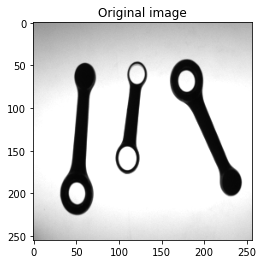

In [17]:
# Display original image

original_img = img

plt.imshow(original_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.show()

### Filtering


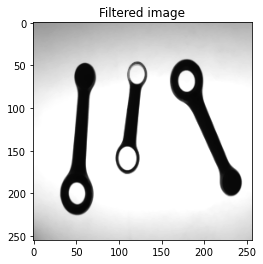

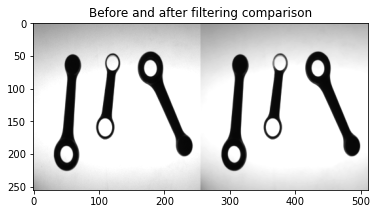

In [18]:
filtered_img = median_filter(original_img)
plt.imshow(filtered_img, cmap='gray', vmin=0, vmax=255)
plt.title('Filtered image')
plt.show()

# Comparison between original and filtered image
compare = np.concatenate((original_img, filtered_img), axis=1)
plt.imshow(compare, cmap='gray', vmin=0, vmax=255)
plt.title('Before and after filtering comparison')
plt.show()

### Binarization of the filtered image

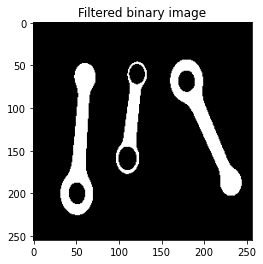

In [19]:
_, bw_filtered_img = cv2.threshold(filtered_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(bw_filtered_img, cmap='gray', vmin=0, vmax=255)
plt.title('Filtered binary image')
plt.show()

### Detachment rods process

In [20]:
# Binarization of the original image
_, bw_original_img = cv2.threshold(original_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# If needed, perform detachment rods process
detached_img, been_detached = detach(bw_original_img)

if been_detached:
      plt.imshow(detached_img)
      plt.title('Unfiltered binary image after detachment rods process')
      plt.show()

### Detachment & filtering merging

In [21]:
# If needed, merging of the binary filtered (non-detached) image and the binary (unfiltered) detached image
if been_detached:

    bw_detached_img =  cv2.cvtColor(detached_img, cv2.COLOR_RGB2GRAY)

    min_img = np.zeros((bw_detached_img.shape[0],bw_detached_img.shape[1]), np.uint8)

    # Pixel-wise comparison in order to keep, for each pixel position, the minimum value between the two images
    for i in range(0,bw_detached_img.shape[0]):
      for j in range(0,bw_detached_img.shape[1]):
        min_img[i,j] = min(bw_detached_img[i,j], bw_filtered_img[i,j])
    
    plt.imshow(min_img, cmap='gray', vmin=0, vmax=255)
    plt.title('Final binary image')
    plt.show()

    # Final binary image, resulting from the merging of the filtered and the detached ones
    final_bw_img = min_img
    
else:

    # If no detachment was performed, take as final binary image the filtered one
    final_bw_img = bw_filtered_img

### Connected components labeling

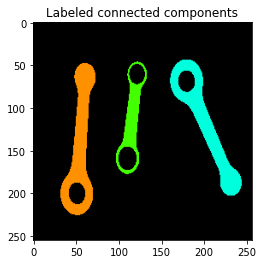

In [22]:
(n_labels, labels, stats, _) = cv2.connectedComponentsWithStats(final_bw_img, 4, cv2.CV_32S)

# Showing connected components labeling
show_connected_components(labels, 103)

### Components analysis & output information 


--------------------------------------------- ROD 1 ---------------------------------------------


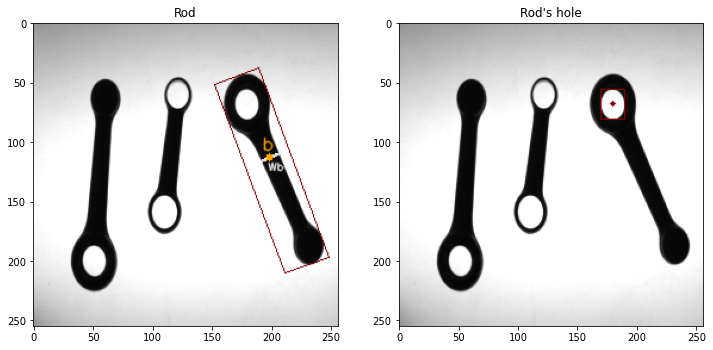


Type: A
Position: (198, 113)
Orientation: 112.98°
Lenght: 169.35
Width: 39.78
Width at Barycenter: 15.23

Hole position: (179, 68)
Hole diameter: 24.17
--------------------------------------------- ROD 2 ---------------------------------------------


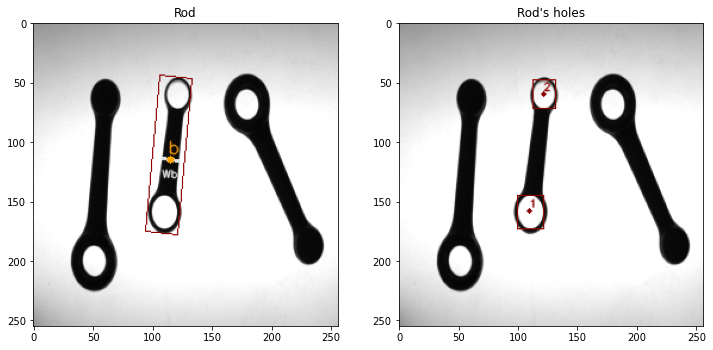


Type: B
Position: (115, 115)
Orientation: 84.0°
Lenght: 131.73
Width: 26.98
Width at Barycenter: 14.14

Hole_1 position: (109, 158)
Hole_1 diameter: 26.61
Hole_2 position: (121, 60)
Hole_2 diameter: 22.9
--------------------------------------------- ROD 3 ---------------------------------------------


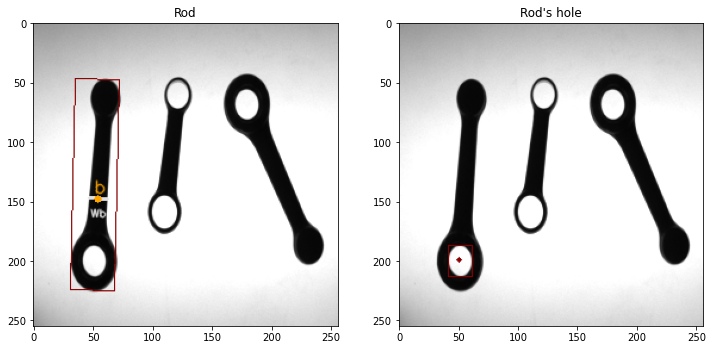


Type: A
Position: (54, 148)
Orientation: 86.1°
Lenght: 177.26
Width: 37.27
Width at Barycenter: 15.03

Hole position: (50, 199)
Hole diameter: 24.44


In [23]:
rgb_img = cv2.cvtColor(bw_filtered_img, cv2.COLOR_GRAY2RGB)
n_distractors = 0

for i in range(1, n_labels):
    
    img = original_img.copy()
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Extract i-th component from the image
    void_img = np.zeros((img.shape[0], img.shape[1]), dtype="uint8")
    component_mask = (labels == i).astype("uint8") * 255 
    component = cv2.bitwise_or(void_img, component_mask)
    component_cnt, _ = cv2.findContours(component,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    # Position 
    centroid = get_centroid(component_cnt[0])
    
    # Get rid of distractors    
    if is_distractor(component, centroid, component_cnt[0]):
        n_distractors = n_distractors + 1
        continue

    # Rotation and bounding box 
    orientation = get_orientation(component_cnt[0])
    _, box = bounding_box(component_cnt[0])
    
    # Width and length
    width, length = get_dimensions(component_cnt[0])
    
    # Barycenter width
    bar_width, p1, p2 = get_barycenter_width(img, component_cnt[0], centroid, orientation)
        
    # Holes features
    holes_number, holes_centroids, holes_diameters, holes_cnt = get_holes_features(rgb_img, component)

    # Output information and visualization
    output_information(img, i-n_distractors, holes_number, centroid, orientation, length, 
                   width, bar_width, holes_centroids, holes_diameters, box, p1, p2)